In [12]:
import numpy as np
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import random
from torchvision import transforms
import glob
import os

In [80]:
class SingleDeformer:
    def __init__(self, img_size) -> None:
        self.img_size = img_size
    def getmesh(self, img):
        #Map a target rectangle onto a source quad
        return [(
                # target rectangle
                (0,0,self.img_size[0],self.img_size[1]),
                # corresponding source quadrilateral
                (np.random.randint(0,255), 
                 np.random.randint(0,255),
                 np.random.randint(0,255),
                 np.random.randint(0,255),
                 np.random.randint(0,255),
                 np.random.randint(0,255),
                 np.random.randint(0,255),
                 np.random.randint(0,255))
                )]

In [81]:
def generate_rotations(image:Image):
  r90 = image.rotate(90)
  r180 = image.rotate(180)
  r270 = image.rotate(270)
  return image, r90, r180, r270


def generate_patch(image:Image, 
                    area_ratio=(0.02, 0.15), 
                    aspect_ratio=((0.3, 1),(1, 3.3))):
  #print('generate_patch', area_ratio)
  img_area = image.size[0] * image.size[1]
  patch_area = random.uniform(area_ratio[0], area_ratio[1]) * img_area
  patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
  patch_w  = int(np.sqrt(patch_area*patch_aspect))
  patch_h = int(np.sqrt(patch_area/patch_aspect))
  org_w, org_h = image.size
  deformed = ImageOps.deform(image, SingleDeformer(image.size))
  patch_left, patch_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  patch_right, patch_bottom = patch_left + patch_w, patch_top + patch_h
  paste_left, paste_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  
  return deformed.crop((patch_left, patch_top, patch_right, patch_bottom)), (paste_left, paste_top)


def paste_patch(image, patch, coords, mask = None):
  aug_image = image.copy()
  aug_image.paste(patch, (coords[0], coords[1]), mask=mask)
  return aug_image


def apply_patch_augmentations(patch:Image, 
                              augmentations:transforms.ColorJitter=None):
  #patch = patch.filter(ImageFilter.GaussianBlur(random.randint(0, 2)))
  return augmentations(patch)


def random_color():
  return random.randint(10,240)


def generate_scar(imsize:tuple, 
                  w_range=(2,16), 
                  h_range=(10,25)):
  img_w, img_h = imsize

  #dimensioni sezione
  scar_w = random.randint(w_range[0], w_range[1])
  scar_h = random.randint(h_range[0], h_range[1])

  r = random_color()
  g = random_color()
  b = random_color()

  color = (r,g,b)

  scar = Image.new('RGBA', (scar_w, scar_h), color=color)
  angle = random.randint(-45, 45)
  scar = scar.rotate(angle, expand=True)

  #posizione casuale della sezione
  left, top = random.randint(0, img_w - scar_w), random.randint(0, img_h - scar_h)
  return scar, (left, top)

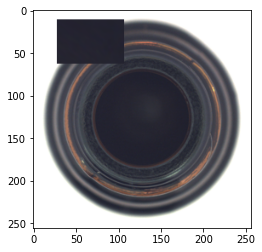

In [115]:
imsize=(256,256)
img = Image.open("../dataset/bottle/train/good/000.png").resize(imsize).convert('RGB')
patch, coords = generate_patch(img)
plt.imshow(patch)
plt.imshow(paste_patch(img, patch, coords))